In [5]:
%matplotlib inline
import scipy as sp
from scipy import io
import numpy as np
import matplotlib.pyplot as plt

### load data

Text(0.5,1,'SATs per hour')

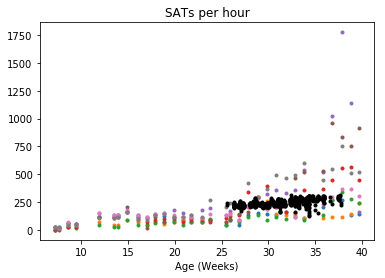

In [6]:
org_feat_file = '/Users/rdgao/Documents/data/Muotri/Pri_Corticoids/ctc_EMAfeatures.mat'
org_data = io.loadmat(org_feat_file, squeeze_me=True)
org_feat = org_data['ctc_EMAfeatures']
org_age = org_data['dayVec']

# stack organoid features, original dimensions are (session x wells x feature)
org_feat_stacked = np.reshape(org_feat, (np.prod(org_feat.shape[:2]), org_feat.shape[2]))
org_age_stacked = np.repeat(org_age, org_feat.shape[1])
org_id_stacked = np.reshape(np.matmul(np.ones((org_feat.shape[0],1)), np.expand_dims(np.arange(8),0)), -1)


baby_feat_file = '/Users/rdgao/Documents/data/Muotri/InfantEEGFeatures/preterm_features.mat'
baby_data = sp.io.loadmat(baby_feat_file, squeeze_me=True)
baby_data.keys()
baby_feat = baby_data['features_fullepoch']

# split age array into columns
baby_num, baby_pma, baby_ema = baby_data['age'].T

# only want certain columns of features
feat_cols = [6,7,8,9,10,11,12,13,14,19,20,21,22]
feat_names = ['SATs per hour',
'RMS SAT duration',
'SAT duration (50%)',
'SAT duration (5%)',
'SAT duration (95%)',
'RMS Inter-SAT Duration',
'Inter-SAT duration (50%)',
'Inter-SAT duration (5%)',
'Inter-SAT duration (95%)',
'Relative Delta Power',
'Relative Theta Power',
'Relative Alpha Power',
'Relative Beta Power']

feat_ind = 0
plt.plot(org_age, org_feat[:,:,feat_cols[feat_ind]], '.');
plt.plot(baby_pma, baby_feat[:,feat_cols[feat_ind]],'.k');
plt.xlabel('Age (Weeks)')
plt.title(feat_names[feat_ind])

### Linear regression

In [7]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import Imputer
# for filling in missing data
imputer = Imputer()

def brainballbaby_linreg(x_train, y_train, x_test, y_test, feat_cols, age_range=None):
    # Create linear regression object
    regr = linear_model.LinearRegression()

    if age_range is None:
        age_inds_train = np.arange(len(y_train))
        age_inds_test  = np.arange(len(y_test))
    else:
        age_inds_train = np.logical_and(y_train>age_range[0], y_train<age_range[1])
        age_inds_test  = np.logical_and(y_test>age_range[0], y_test<age_range[1])

    # Train the model using the training sets
    regr.fit(imputer.fit_transform(x_train[age_inds_train,:][:,feat_cols]), y_train[age_inds_train])

    # Make predictions using the testing set
    y_pred = regr.predict(imputer.fit_transform(x_test[age_inds_test,:][:,feat_cols]))

    plt.figure(figsize=(8,4))
    plt.plot(y_test[age_inds_test], y_pred, '.')
    plt.xlabel('Actual Age (Wks)')
    plt.ylabel('Predicted Age (Wks)')
    
    # The mean squared error
    print("Mean squared error: %.2f" % mean_squared_error(y_test[age_inds_test], y_pred))
    # Explained variance score: 1 is perfect prediction
    print('Variance score: %.2f' % r2_score(y_test[age_inds_test], y_pred))
    # Correlation
    print('Correlation Coef: %.2f, P-Value: %.5f' % sp.stats.pearsonr(y_test[age_inds_test], y_pred))

Mean squared error: 5722.65
Variance score: -60.33
Correlation Coef: -0.49, P-Value: 0.00000


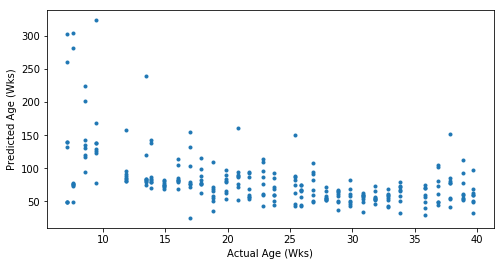

In [30]:
# full features, all ages, baby -> org
brainballbaby_linreg(baby_feat, baby_pma, org_feat_stacked, org_age_stacked, feat_cols)

Mean squared error: 39.67
Variance score: -3.44
Correlation Coef: -0.08, P-Value: 0.04418


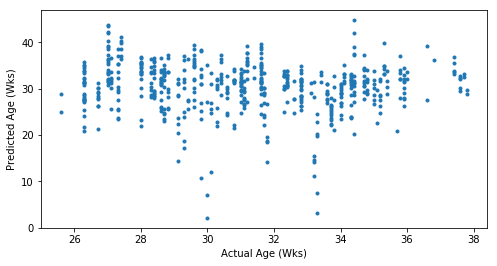

In [9]:
# full features, all ages, org -> baby
brainballbaby_linreg(org_feat_stacked, org_age_stacked, baby_feat, baby_pma, feat_cols)

### restricting age range (25-38 weeks old data only)

Mean squared error: 1438.23
Variance score: -89.11
Correlation Coef: -0.00, P-Value: 0.96019


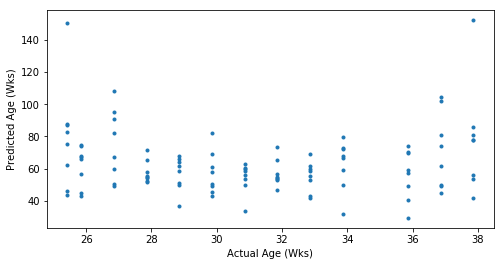

In [42]:
# full features, 25-38wk, baby -> org
brainballbaby_linreg(baby_feat, baby_pma, org_feat_stacked, org_age_stacked, feat_cols, age_range=(25,38))

Mean squared error: 36.19
Variance score: -3.05
Correlation Coef: 0.25, P-Value: 0.00000


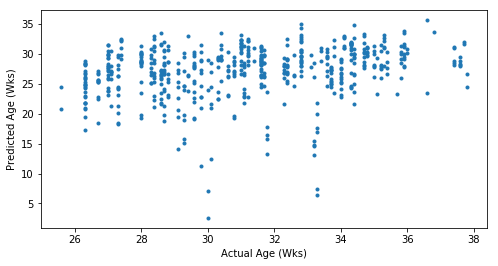

In [43]:
# full features, 25-38wk, org -> baby
brainballbaby_linreg(org_feat_stacked, org_age_stacked, baby_feat, baby_pma, feat_cols, age_range=(25,38))

### restricting features (exclude spectral features)

In [44]:
feat_names

['SATs per hour',
 'RMS SAT duration',
 'SAT duration (50%)',
 'SAT duration (5%)',
 'SAT duration (95%)',
 'RMS Inter-SAT Duration',
 'Inter-SAT duration (50%)',
 'Inter-SAT duration (5%)',
 'Inter-SAT duration (95%)',
 'Relative Delta Power',
 'Relative Theta Power',
 'Relative Alpha Power',
 'Relative Beta Power']

Mean squared error: 984.61
Variance score: -9.55
Correlation Coef: 0.62, P-Value: 0.00000


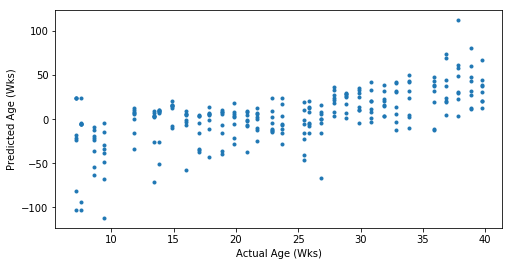

In [45]:
# no spectral features, all ages, baby -> org
brainballbaby_linreg(baby_feat, baby_pma, org_feat_stacked, org_age_stacked, feat_cols[:-4])

Mean squared error: 687.29
Variance score: -42.06
Correlation Coef: 0.54, P-Value: 0.00000


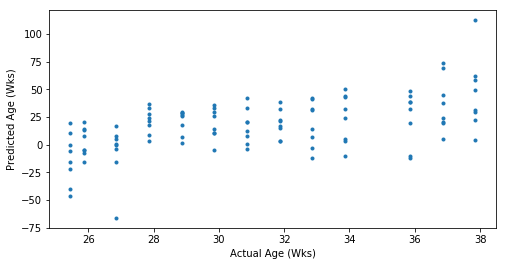

In [49]:
# no spectral features, all ages, org -> baby
brainballbaby_linreg(baby_feat, baby_pma, org_feat_stacked, org_age_stacked, feat_cols[:-4], age_range=(25, 38))

Mean squared error: 78.76
Variance score: -7.81
Correlation Coef: 0.17, P-Value: 0.00004


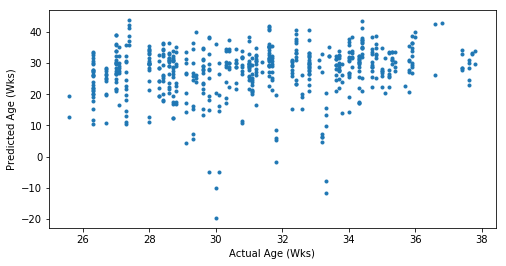

In [52]:
# no spectral features, 25-38wks, baby -> org
brainballbaby_linreg(org_feat_stacked, org_age_stacked, baby_feat, baby_pma, feat_cols[:-4])

Mean squared error: 32.49
Variance score: -2.64
Correlation Coef: 0.23, P-Value: 0.00000


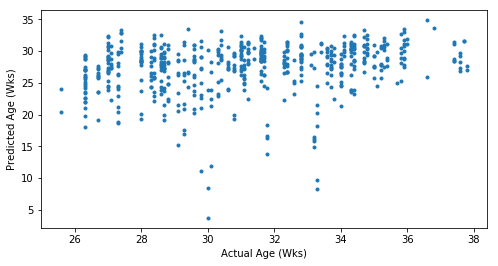

In [53]:
# no spectral features, 25-38wks, org -> baby
brainballbaby_linreg(org_feat_stacked, org_age_stacked, baby_feat, baby_pma, feat_cols[:-4], age_range=(25,38))